In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=149)

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41351 entries, 1854-01-01 00:00:00 to 2024-02-06
Data columns (total 26 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Predicted ice thickness [m]                        38563 non-null  float64
 4   Noisy predicted ice thickness [m]                  25762 non-null  float64
 5   Nenana: Rainfall [mm]                              29547 non-null  float64
 6   Nenana: Snowfall [mm]                              19945 non-null  float64
 7   Nenana: Snow depth [mm]                            15984 non-null  float64
 8   Nenana: Mean water temperature [C]                 2418 non-null   f


## Ashton's Formula
Ashton's formula to predict the ice growth is an improved version of Stefan's formual [[1]](https://static1.1.sqspcdn.com/static/f/572109/18056158/1336339358653/thin+ice+growth.pdf?token=9mlCTJ8q6DFV3imaaSj54iHJW%2FQ%3D))

$$\frac{dH}{dt}=\left(\frac{1}{\rho L}\right)\frac{T_m-T_a}{\frac{h}{k}+\frac{1}{H_{ia}}}$$

First, lets assume reasonable values for the constant, predict the ice growth and compare it with the measurement.

 (all value from Wolfram Alpha knowledge database)
- Ice density - $\rho=997.048 [kg/m^3] $
- Ice heat of fusion(specific) -  $L=334000 [J/kg]$
- Ice fusion temperature - $T_m=0[°C]$
- Ice thermal conductivity - $k=0.598 [W/(m °C)]$
- Heat transfer coeficient -$H_{ia}=20 [W/(m^2 °C)]$

Variables
- t[s]
- h[m]


### Assumptions
- The ice thickness is set to zero  for days (150-250) of each year
- The temperature is constant throughout the day

In [31]:
cutoff_0=150
cutoff_1=250
# defining constants
rho = 997.048
L = 334000
Tm = 0
k = 0.598
Hia = 20

Method_1 = pd.DataFrame(0, index=Data.index, columns=['Predicted thickness [m]'])
Method_1['Regional: Air temperature [C]']=Data['Regional: Air temperature [C]']
Method_1['Days until break up']=Data['Days until break up']
Method_1=Method_1.dropna()
Method_1.index=pd.to_datetime(Method_1.index)
Method_1_1=Method_1.copy()
Method_2=Method_1.copy()
# Year-loop
for year in Method_1.index.year.unique():
    df_year = Method_1[Method_1.index.year == year].copy()
    if year > Method_1.index.year.min():
        # Get the ice thickness from December 31st of the previous year
        thickness_last_year = Method_1.loc[Method_1.index.year == year - 1, 'Predicted Ice Thickness [m]'].iloc[-1]
        # Set the ice thickness for January 1st of the current year to be the same as December 31st of the previous year
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted Ice Thickness [m]'] = thickness_last_year
    else: # for the first year set January 1st thickness to 0.9
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted Ice Thickness [m]'] = 0.9
# loop days
    for i in range(1, len(df_year)):
        H_prev = df_year.at[df_year.index[i - 1], 'Predicted Ice Thickness [m]']
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']
        delta_H = (1) / (rho * L) * (Tm - T_current) / (H_prev / k + 1 / Hia)
        Predicted_H = (H_prev + delta_H * 86400)*1  # seconds in a day
        #print(Predicted_H)
        # here we force zero thickness in summer
        if cutoff_0 <= df_year.index[i].dayofyear <= cutoff_1:
            Predicted_H = 0
        elif Predicted_H <= 0:
            Predicted_H = 0
        df_year.at[df_year.index[i], 'Predicted Ice Thickness [m]'] = Predicted_H
    Method_1.loc[df_year.index, 'Predicted Ice Thickness [m]'] = df_year['Predicted Ice Thickness [m]']


In [34]:
# Year-loop
for year in Method_1_1.index.year.unique():
    df_year = Method_1_1[Method_1_1.index.year == year].copy()
    if year > Method_1_1.index.year.min():
        # Get the ice thickness from December 31st of the previous year
        thickness_last_year = Method_1_1.loc[Method_1_1.index.year == year - 1, 'Predicted Ice Thickness [m]'].iloc[-1]
        # Set the ice thickness for January 1st of the current year to be the same as December 31st of the previous year
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted Ice Thickness [m]'] = thickness_last_year
    else: # for the first year set January 1st thickness to 0.9
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted Ice Thickness [m]'] = 0.9
# loop days
    for i in range(1, len(df_year)):
        H_prev = df_year.at[df_year.index[i - 1], 'Predicted Ice Thickness [m]']
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']
        delta_H = (1) / (rho * L) * (Tm - T_current) / (H_prev / k + 1 / Hia)
        Predicted_H = (H_prev + delta_H * 86400)*1  # seconds in a day
        df_year.at[df_year.index[i], 'Predicted Ice Thickness [m]'] = Predicted_H
    Method_1_1.loc[df_year.index, 'Predicted Ice Thickness [m]'] = df_year['Predicted Ice Thickness [m]']


# Stefan's Formula
> "*The classical Stefan Problem aims to determine how an ice layer grows as a function of time, given the constraint that air the air temperature Tair is constant, smaller h ice icethan Tfr and everywhere the same*."


# Comparison

Text(0.5, 1.0, 'Ice growth')

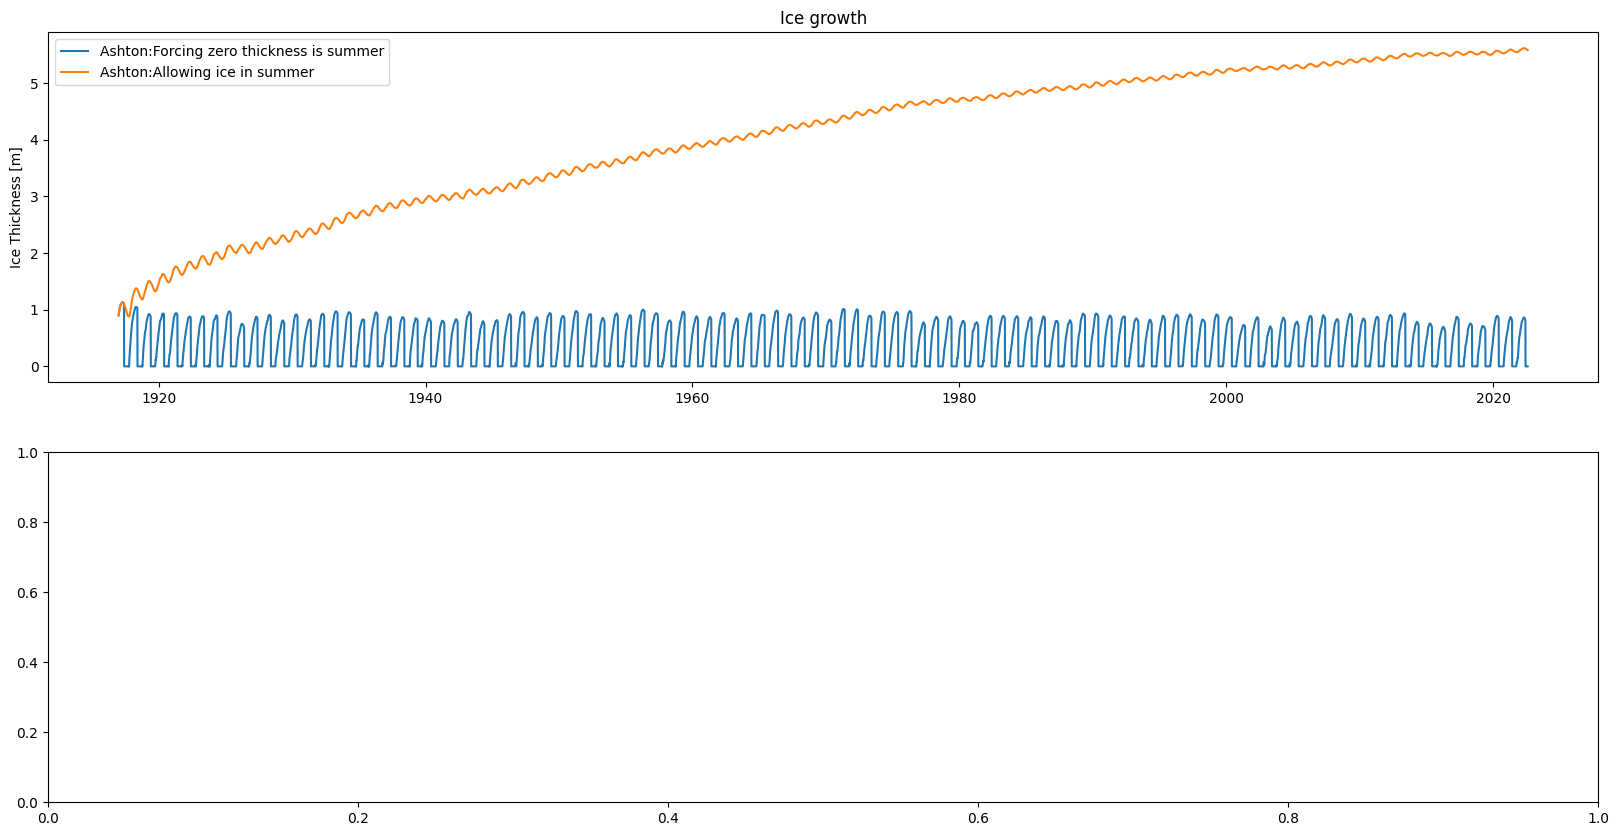

In [35]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(Method_1['Predicted Ice Thickness [m]'],label='Ashton:Forcing zero thickness is summer')
ax[0].plot(Method_1_1['Predicted Ice Thickness [m]'],label='Ashton:Allowing ice in summer')
#ax[0].plot(Method_2['Predicted Ice Thickness [m]'],label='Ashton:Allowing ice in summer')
ax[0].set_ylabel('Ice Thickness [m]')
ax[0].legend()
ax[0].set_title("Ice growth")
# ax[1].scatter(Method_1['Days until break up'],Method_1['Predicted Ice Thickness [m]'],alpha=0.4,marker='2',label='Ashton:Forcing zero thickness is summer')
# ax[1].scatter(Method_1_1['Days until break up'],Method_1_1['Predicted Ice Thickness [m]'],alpha=0.4,marker='1',label='Ashton: Allowing ice in summer')
# ax[1].set_ylabel('Ice Thickness [m]')
# ax[1].legend()
# ax[1].set_title("Ice growth")
# ax[1].set_ylim([0,5])